# Sentence Embedding Time Series Generation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
import random
import ast
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from gensim.utils import tokenize
from gensim.models import Doc2Vec

In [2]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [3]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,40043,"[""When I'm lyin' in my bed at night"", ""I don't...",rock,40043,"[""When I'm lyin' with my sisters face first"", ...","['Every night I hope and pray', 'A dream lover..."
1,48922,"['Love is like problems', ""We all got 'em"", 'A...",rock,48922,"['Love spreads like magic', ""We seriously need...","['You can be amazing', 'You can turn a phrase ..."
2,41840,"[""As I was motivatin'"", 'Back in town', 'I saw...",rock,41840,"[""As Katrina was ''"", 'Back to town', 'I saw t...","[""I love it when we're cruisin' together"", ""I ..."
3,39964,"['Oh love, oh love', ""Won't you rain on me ton...",rock,39964,"['Oh my, no love', ""Won't you rain down it too...","['Galleria:', 'When I was just a little girl',..."
4,37806,"['Take my breath away', ""I don't need it anywa...",rock,37806,"['Take you breath carefully', 'I kinda want it...","['Tuesday seemed like it was thursday', 'Yeste..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           150 non-null    int64 
 1   lyrics          150 non-null    object
 2   genre           150 non-null    object
 3   id              150 non-null    int64 
 4   similar_lyrics  150 non-null    object
 5   random_lyrics   150 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.2+ KB


In [5]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))
df['similar_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['similar_lyrics']))
df['random_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['random_lyrics']))

In [6]:
random.choice(df['lyrics'])

['Take me back',
 'Hold my hand',
 'All the way back',
 'To the brotherland',
 'Take me back',
 'I want to go back',
 'Take me back',
 'And my funky ass band',
 'All the way back',
 'To the broherland',
 'Take me back',
 'I want to go',
 'As fast as I can',
 "Slidin' on back",
 'To the brotherland',
 'Now children',
 'Hollywood...',
 'I want to get up and go',
 'With my funky ass jams',
 'All the way back',
 'To the broherland',
 'Take me back',
 'I want to go back',
 'Hollywood...',
 'Where the women',
 'Is the women',
 'And the man',
 'Is the man',
 'I want to go',
 'As fast as I can',
 "Slidin' on back",
 'To the brotherland']

## Sentence BERT

In [7]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"I wake up every morning, with the sun in my eyes",verse
1,"I stumble out of bed, and I hit the ground run...",verse
2,"I've got a lot on my plate, but I don't mind t...",verse
3,"I know I've got what it takes, to make it down...",verse
4,"I'm living for today, and I'm chasing my dreams",chorus


In [8]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['I wake up every morning, with the sun in my eyes',
 'I stumble out of bed, and I hit the ground running',
 "I've got a lot on my plate, but I don't mind the load",
 "I know I've got what it takes, to make it down the road",
 "I'm living for today, and I'm chasing my dreams",
 "I won't let anyone stand in my way, or burst at the seams",
 "I'm on a mission, to reach for the stars",
 "I'm unstoppable, behind the steering wheel of my car",
 "I hit the pavement, and I don't look back",
 "I've got my foot on the gas, and I'm on the right track",
 "I know I've got what it takes, to make it to the top",
 "I won't stop until I reach the mountaintop",
 "I'm living for today, and I'm chasing my dreams",
 "I won't let anyone stand in my way, or burst at the seams",
 "I'm on a mission, to reach for the stars",
 "I'm unstoppable, behind the steering wheel of my car",
 "I've got my eyes on the prize, and I won't let it go",
 "I'll keep on fighting, with all my might and my mojo"]

In [9]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate a multivariate time series for text ad a sequence of sentence embedding (SBERT)
generate_multi_ts = lambda lyrics, model: np.array([model.encode(verse) for verse in lyrics])

In [10]:
eg_multi_ts = generate_multi_ts(eg_lyrics, model)
eg_multi_ts.shape



(18, 384)

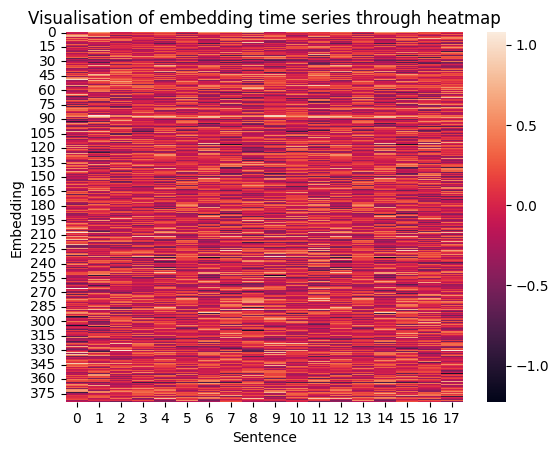

In [11]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('Sentence')
ax.set_ylabel('Embedding')
ax.set_title('Visualisation of embedding time series through heatmap')
plt.show()

In [12]:
parts_of_lyrics = list(toy_lyrics['part'])
color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(parts_of_lyrics))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

In [13]:
eg_uniavg_ts = np.mean(eg_multi_ts, axis=1)

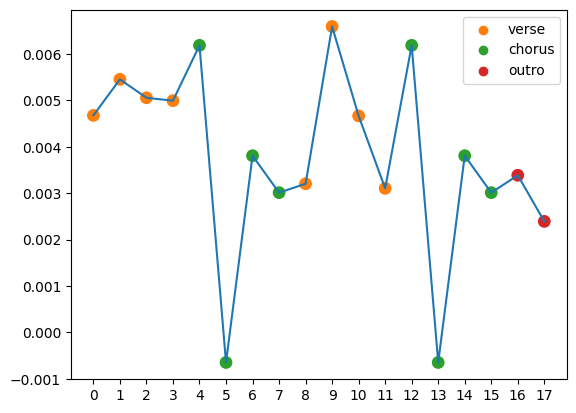

In [14]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_uniavg_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_uniavg_ts, 
                     x = range(len(eg_uniavg_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_uniavg_ts)))
plt.show()

In [15]:
eg_unimax_ts = np.max(eg_multi_ts, axis=1)

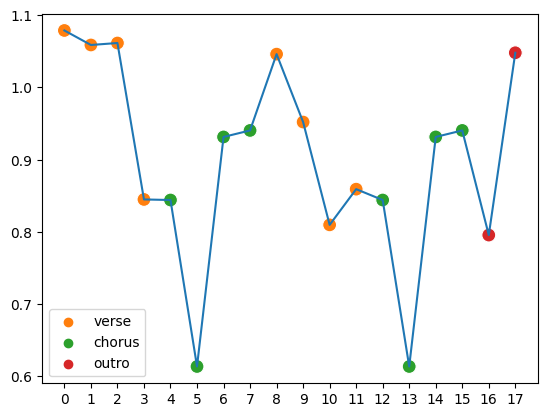

In [16]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_unimax_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_unimax_ts, 
                     x = range(len(eg_unimax_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_unimax_ts)))
plt.show()

In [17]:
ss = StandardScaler()
pca = PCA(n_components=1, random_state=0)

eg_norm_multi_ts = ss.fit_transform(eg_multi_ts)

eg_unipca_ts = np.array([pc[0] for pc in pca.fit_transform(eg_norm_multi_ts)])

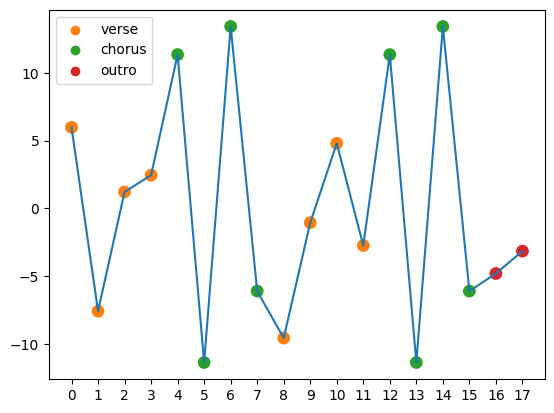

In [18]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_unipca_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_unipca_ts, 
                     x = range(len(eg_unipca_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_unipca_ts)))
plt.show()

In [19]:
def generate_uni_ts(multi_ts, normalize=False, pooling_method='avg'):            
    """
    Convert a multi-variate time series represented as a numpy array into a uni-variate time series.
    
    Parameters
    ----------
    multi_ts : numpy array
        A 2D array representing the multi-variate time series with shape (n_samples, n_features)
    normalize : bool, optional
        Whether to normalize the input data using StandardScaler. Default is False.
    pooling_method : str, optional
        The method to use for pooling the multi-variate time series into a uni-variate time series.
        Must be one of 'avg', 'max', or 'pca'. Default is 'avg'.
        
    Returns
    -------
    uni_ts : numpy array
        A 1D array representing the uni-variate time series with shape (n_samples,)
        
    Raises
    ------
    ValueError
        If an invalid value is passed for the pooling_method
    """
    if normalize:
        ss = StandardScaler()
        multi_ts = ss.fit_transform(multi_ts)        
    if pooling_method=='avg':            
        uni_ts = np.mean(multi_ts, axis=1)            
    elif pooling_method=='max':            
        uni_ts = np.max(multi_ts, axis=1)            
    elif pooling_method=='pca':
        pca = PCA(n_components=1, random_state=0)
        uni_ts = np.array([pc[0] for pc in pca.fit_transform(multi_ts)]) 
    else:
        raise ValueError("Invalid pooling_method passed. Please use either 'avg', 'max' or 'pca'.")        
    return uni_ts

In [20]:
print(any(eg_uniavg_ts == generate_uni_ts(eg_multi_ts, normalize=False, pooling_method='avg')))
print(any(eg_unimax_ts == generate_uni_ts(eg_multi_ts, normalize=False, pooling_method='max')))
print(any(eg_unipca_ts == generate_uni_ts(eg_multi_ts, normalize=True, pooling_method='pca')))

True
True
True


In [21]:
pooling_methods = [('avg', False), ('max', False), ('pca', True)]

for pooling_method, norm_par in pooling_methods:
    print(f'{pooling_method}:')    
    ts_data = {}
    for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
        print(lyrics_type)
        ts_data[lyrics_type] = []
        for lyr in tqdm(df[lyrics_type]):
            multi_ts = generate_multi_ts(lyr, model)
            uni_ts = generate_uni_ts(multi_ts, 
                                     normalize=norm_par, 
                                     pooling_method=pooling_method)
            ts_data[lyrics_type].append(uni_ts)
    ts_data = pd.DataFrame(ts_data)
    filename = f'../data/evaluation/sbert-ts/{pooling_method}.csv'
    ts_data.to_csv(filename, index=False)
    print('___')

avg:
lyrics


100%|██████████| 150/150 [03:44<00:00,  1.49s/it]


similar_lyrics


100%|██████████| 150/150 [04:31<00:00,  1.81s/it]


random_lyrics


100%|██████████| 150/150 [03:41<00:00,  1.48s/it]


___
max:
lyrics


100%|██████████| 150/150 [04:03<00:00,  1.62s/it]


similar_lyrics


100%|██████████| 150/150 [04:46<00:00,  1.91s/it]


random_lyrics


100%|██████████| 150/150 [47:08<00:00, 18.85s/it]   


___
pca:
lyrics


100%|██████████| 150/150 [04:08<00:00,  1.65s/it]


similar_lyrics


100%|██████████| 150/150 [04:29<00:00,  1.80s/it]


random_lyrics


100%|██████████| 150/150 [03:35<00:00,  1.44s/it]


___


## Doc2Vec

In [22]:
tokenize_lyrics = lambda x: [list(tokenize(verse, lowercase=True)) for verse in x]

tokenized_lyrics = list(map(tokenize_lyrics, df['lyrics']))
tokenized_sim_lyrics = list(map(tokenize_lyrics, df['similar_lyrics']))
tokenized_rnd_lyrics = list(map(tokenize_lyrics, df['random_lyrics']))

In [23]:
random.choice(tokenized_rnd_lyrics)

[['another', 'one'],
 ['we', 'the', 'best', 'music'],
 ['yeah', 'yeah', 'yeah', 'yeah', 'yeah', 'yeah', 'yeah'],
 ['dj', 'khaled'],
 ['lamborghini', 'got', 'a', 's'],
 ['parking', 'lot', 'look', 'like', 'a', 'movie'],
 ['my', 'sex', 'drive', 'leave', 'her', 'woozy'],
 ['got', 'my', 'b', 'a', 'b', 'y', 'in', 'the', 'two', 'seat'],
 ['i', 'ain', 't', 'i', 'ain', 't', 'even', 'got', 'no', 'time', 'to', 'talk'],
 ['it', 's', 'all', 'up', 'to', 'you', 'baby'],
 ['diamonds', 'dancing', 'on', 'my', 'rubies'],
 ['savage', 'mode', 'is', 'on', 'ruthless'],
 ['nah',
  'i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you',
  'i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you'],
 ['i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you',
  'i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you'],
 ['i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you',
  'i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you'],
 ['i',
  'can',
  't',
  'even',
  'lie',
  'to',
  'you',
  'i',
  'can',
  't',

In [24]:
model = Doc2Vec.load("../models/doc2vec.model")

In [25]:
# Generate a multivariate time series for text ad a sequence of sentence embedding (Doc2Vec)
generate_multi_ts = lambda lyrics, model: np.array([model.infer_vector(verse) for verse in lyrics])

In [26]:
eg_tokenized_lyrics = tokenize_lyrics(eg_lyrics)

eg_multi_ts = generate_multi_ts(eg_tokenized_lyrics, model)
eg_multi_ts.shape

(18, 100)

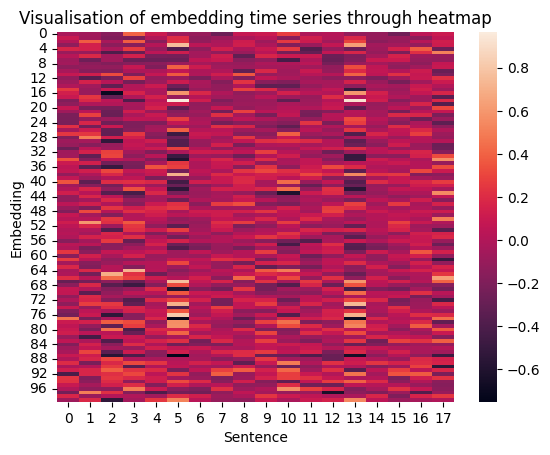

In [27]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('Sentence')
ax.set_ylabel('Embedding')
ax.set_title('Visualisation of embedding time series through heatmap')
plt.show() 

In [28]:
model1 = Doc2Vec.load("../models/doc2vec1.model")

dismantle_fake_nested_list = lambda nested_list: [unique_element[0] for unique_element in nested_list]

eg_unid2v_ts = dismantle_fake_nested_list(generate_multi_ts(eg_tokenized_lyrics, model1))


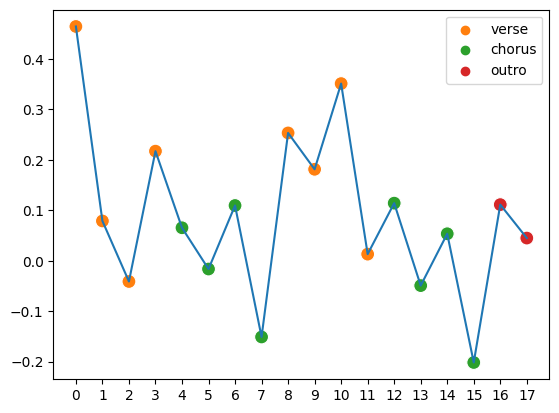

In [29]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_unid2v_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_unid2v_ts, 
                     x = range(len(eg_unid2v_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_unid2v_ts)))
plt.show()

In [30]:

pooling_methods = [('avg', False), ('max', False), ('pca', True)]

for pooling_method, norm_par in pooling_methods:
    print(f'{pooling_method}:')    
    ts_data = {}
    for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
        print(lyrics_type)
        ts_data[lyrics_type] = []
        for lyr in tqdm(df[lyrics_type]):
            tokenized_lyr = tokenize_lyrics(lyr)
            multi_ts = generate_multi_ts(tokenized_lyr, model)
            uni_ts = generate_uni_ts(multi_ts, 
                                     normalize=norm_par, 
                                     pooling_method=pooling_method)
            ts_data[lyrics_type].append(uni_ts)
    ts_data = pd.DataFrame(ts_data)
    filename = f'../data/evaluation/doc2vec-ts/{pooling_method}.csv'
    ts_data.to_csv(filename, index=False)
    print('___')

avg:
lyrics


100%|██████████| 150/150 [00:12<00:00, 12.40it/s]


similar_lyrics


100%|██████████| 150/150 [00:12<00:00, 11.64it/s]


random_lyrics


100%|██████████| 150/150 [00:10<00:00, 14.21it/s]


___
max:
lyrics


100%|██████████| 150/150 [00:11<00:00, 12.77it/s]


similar_lyrics


100%|██████████| 150/150 [00:12<00:00, 12.46it/s]


random_lyrics


100%|██████████| 150/150 [00:07<00:00, 19.35it/s]


___
pca:
lyrics


100%|██████████| 150/150 [00:13<00:00, 11.28it/s]


similar_lyrics


100%|██████████| 150/150 [00:14<00:00, 10.08it/s]


random_lyrics


100%|██████████| 150/150 [00:10<00:00, 13.67it/s]


___


In [31]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    print(lyrics_type)
    ts_data[lyrics_type] = []
    for lyr in tqdm(df[lyrics_type]):
        tokenized_lyr = tokenize_lyrics(lyr)
        uni_ts = dismantle_fake_nested_list(generate_multi_ts(tokenized_lyr, model1))
        ts_data[lyrics_type].append(uni_ts)
ts_data = pd.DataFrame(ts_data)
filename = '../data/evaluation/doc2vec-ts/d2v.csv'
ts_data.to_csv(filename, index=False)
        
        

lyrics


100%|██████████| 150/150 [00:10<00:00, 14.66it/s]


similar_lyrics


100%|██████████| 150/150 [00:11<00:00, 13.08it/s]


random_lyrics


100%|██████████| 150/150 [00:09<00:00, 16.09it/s]
